In [53]:
!pip install catboost

In [106]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.preprocessing import OneHotEncoder,label_binarize , LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils import resample
# from pytorch_tabular import TabularModel
# from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig, ExperimentConfig
# from pytorch_tabular.models import TabTransformerConfig
# import torch
# from pytorch_tabnet.tab_model import TabNetClassifier
from catboost import CatBoostClassifier
import catboost


In [55]:
df_info = pd.read_csv('/content/drive/MyDrive/EMR/Patient_information_cleaned.csv')
df_complications = pd.read_csv('/content/drive/MyDrive/EMR/Processed_patient_post_op_complications.csv')


In [56]:
df_info.columns

Index(['LOG_ID', 'MRN', 'DISCH_DISP_C', 'DISCH_DISP', 'LOS', 'ICU_ADMIN_FLAG',
       'SURGERY_DATE', 'BIRTH_DATE', 'WEIGHT', 'SEX', 'PRIMARY_ANES_TYPE_NM',
       'ASA_RATING_C', 'ASA_RATING', 'PATIENT_CLASS_GROUP', 'PATIENT_CLASS_NM',
       'PRIMARY_PROCEDURE_NM', 'PATIENT_CLASS_NM_ENCODED',
       'PATIENT_CLASS_GROUP_ENCODED', 'OR_LOS_HOURS', 'AN_LOS_HOURS',
       'HEIGHT_METRES', 'PRIMARY_PROCEDURE_NM_ENCODED',
       'PRIMARY_ANES_TYPE_NM_ENCODED'],
      dtype='object')

In [57]:
df_complications.columns

Index(['LOG_ID', 'MRN', 'SMRTDTA_ELEM_VALUE', 'CONTEXT_NAME_encoded',
       'Post_OP_type_AN  ADMINISTRATIVE', 'Post_OP_type_AN  AIRWAY',
       'Post_OP_type_AN  CARDIOVASCULAR', 'Post_OP_type_AN  CHRONIC PAIN',
       'Post_OP_type_AN  INJURY/INFECTION', 'Post_OP_type_AN  MEDICATION',
       'Post_OP_type_AN  METABOLIC', 'Post_OP_type_AN  NEUROLOGICAL',
       'Post_OP_type_AN AQI ', 'Post_OP_type_ANE  OTHER',
       'Post_OP_type_ANE  REGIONAL', 'Post_OP_type_ANE  RESPIRATORY',
       'SMRTDTA_embeddings'],
      dtype='object')

In [58]:
df_info['Unique_Key'] = df_info['MRN'].astype(str) + ':_:' + df_info['LOG_ID'].astype(str).str.strip()
df_complications['Unique_Key'] = df_complications['MRN'].astype(str) + ':_:' + df_complications['LOG_ID'].astype(str).str.strip()

In [59]:
common_keys = set(df_info['Unique_Key']).intersection(set(df_complications['Unique_Key']))


In [60]:
len(common_keys)

59441

In [61]:
len(df_info['LOG_ID']) , len(df_info['LOG_ID'].unique())

(64124, 62796)

In [62]:
len(set(df_complications['LOG_ID']+" "+df_complications['MRN']).intersection(set(df_info['LOG_ID']+" "+df_info['MRN'])))

59441

In [63]:
len(df_complications['LOG_ID']) , len(df_complications['LOG_ID'].unique())


(203945, 64214)

In [64]:
df1_filtered = df_info[df_info['Unique_Key'].isin(common_keys)]
df2_filtered = df_complications[df_complications['Unique_Key'].isin(common_keys)]

merged_df = pd.merge(df1_filtered, df2_filtered, on='Unique_Key', suffixes=('_info', '_complications'))


In [65]:
df1_filtered.head()

,LOG_ID,MRN,DISCH_DISP_C,DISCH_DISP,LOS,ICU_ADMIN_FLAG,SURGERY_DATE,BIRTH_DATE,WEIGHT,SEX,...,PATIENT_CLASS_NM,PRIMARY_PROCEDURE_NM,PATIENT_CLASS_NM_ENCODED,PATIENT_CLASS_GROUP_ENCODED,OR_LOS_HOURS,AN_LOS_HOURS,HEIGHT_METRES,PRIMARY_PROCEDURE_NM_ENCODED,PRIMARY_ANES_TYPE_NM_ENCODED,Unique_Key
0,cd1636c6279d73a0,2e92522a5f2a2a22,15.0,Home Routine,1.0,0,2018-12-20,47,2832.47,0,...,Hospital Outpatient Surgery,"INSERTION, PUBOVAGINAL SLING, WITH CYSTOSCOPY",1,1,4.97,4.97,1.68,"[101, 23851, 1010, 9047, 7103, 24965, 27076, 1...",2,2e92522a5f2a2a22:_:cd1636c6279d73a0
1,fc53c06ee2cfe438,b7a91e623d957d8f,16.0,Hospice Facility,21.0,1,2019-09-27,81,2515.01,1,...,Hospital Outpatient Surgery,GI EGD DILATION,1,1,1.58,1.58,1.68,"[101, 21025, 1041, 2290, 2094, 29454, 3370, 102]",2,b7a91e623d957d8f:_:fc53c06ee2cfe438
2,2f0090c47da34608,b68d6c7198f30f73,15.0,Home Routine,3.0,1,2019-04-08,49,1964.74,0,...,Hospital Inpatient Surgery,CRANIECTOMY,0,0,4.08,4.08,1.68,"[101, 13675, 7088, 22471, 16940, 102]",2,b68d6c7198f30f73:_:2f0090c47da34608
4,82f89e10f2855420,c2756216cc89b795,15.0,Home Routine,1.0,0,2019-04-19,44,1880.08,0,...,Hospital Outpatient Surgery,"REVISION, RECONSTRUCTION, BREAST",1,1,6.63,6.63,1.68,"[101, 13921, 1010, 8735, 1010, 7388, 102]",2,c2756216cc89b795:_:82f89e10f2855420
5,8778901eeb9b6166,2e34dcb0791b8c0d,15.0,Home Routine,1.0,0,2020-03-17,59,2640.00,0,...,Hospital Outpatient Surgery,EGD (ESOPHAGOGASTRODUODENOSCOPY),1,1,2.02,2.02,1.68,"[101, 1041, 2290, 2094, 1006, 9686, 7361, 3270...",2,2e34dcb0791b8c0d:_:8778901eeb9b6166


In [66]:
df2_filtered.head()

,LOG_ID,MRN,SMRTDTA_ELEM_VALUE,CONTEXT_NAME_encoded,Post_OP_type_AN ADMINISTRATIVE,Post_OP_type_AN AIRWAY,Post_OP_type_AN CARDIOVASCULAR,Post_OP_type_AN CHRONIC PAIN,Post_OP_type_AN INJURY/INFECTION,Post_OP_type_AN MEDICATION,Post_OP_type_AN METABOLIC,Post_OP_type_AN NEUROLOGICAL,Post_OP_type_AN AQI,Post_OP_type_ANE OTHER,Post_OP_type_ANE REGIONAL,Post_OP_type_ANE RESPIRATORY,SMRTDTA_embeddings,Unique_Key
0,b00c588406aae5cc,1a42f0bed60c5598,missing,0,0,0,0,0,0,0,0,0,1,0,0,0,[],1a42f0bed60c5598:_:b00c588406aae5cc
1,a16571d21874c0a7,596a6dc60f54a0bb,missing,1,0,0,0,0,0,0,0,0,1,0,0,0,[],596a6dc60f54a0bb:_:a16571d21874c0a7
2,a16571d21874c0a7,596a6dc60f54a0bb,missing,1,0,0,0,0,0,0,0,0,1,0,0,0,[],596a6dc60f54a0bb:_:a16571d21874c0a7
4,2ae43a4a39735956,59c5483e0654e105,other,0,0,0,0,0,0,0,0,0,1,0,0,0,[-1.00854790e+00 5.63978493e-01 5.91462553e-...,59c5483e0654e105:_:2ae43a4a39735956
5,c7680ab4d890c0fe,2871383f18be5007,missing,0,0,0,0,0,0,0,0,0,1,0,0,0,[],2871383f18be5007:_:c7680ab4d890c0fe


In [67]:
merged_df['Unique_Key'].value_counts()

,count
Unique_Key,
1bb09d5761661c7d:_:cb6698ea372d68fe,76
1bb09d5761661c7d:_:d900502f8b9aec4d,76
1bb09d5761661c7d:_:eefc566c251f9119,76
1bb09d5761661c7d:_:72ed7f97b834058a,76
1bb09d5761661c7d:_:89112300bdcbe94d,76
...,...
25b833a19c21148d:_:5053e13527575339,1
2a8aa5467084144e:_:a060a15c8b5f3af8,1
9bc4a76271dc37cb:_:820689c63ffc0382,1


In [68]:
merged_df[merged_df['Unique_Key']=='1bb09d5761661c7d:_:cb6698ea372d68fe']

,LOG_ID_info,MRN_info,DISCH_DISP_C,DISCH_DISP,LOS,ICU_ADMIN_FLAG,SURGERY_DATE,BIRTH_DATE,WEIGHT,SEX,...,Post_OP_type_AN CHRONIC PAIN,Post_OP_type_AN INJURY/INFECTION,Post_OP_type_AN MEDICATION,Post_OP_type_AN METABOLIC,Post_OP_type_AN NEUROLOGICAL,Post_OP_type_AN AQI,Post_OP_type_ANE OTHER,Post_OP_type_ANE REGIONAL,Post_OP_type_ANE RESPIRATORY,SMRTDTA_embeddings
61006,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
61007,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
61008,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
61009,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
61010,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82422,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
82423,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
82424,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]
82425,cb6698ea372d68fe,1bb09d5761661c7d,20.0,Home Healthcare IP Admit Related,25.0,1,2021-01-14,36,3033.53,0,...,0,0,0,0,0,1,0,0,0,[]


In [69]:
df_unique = merged_df.drop_duplicates(subset=['Unique_Key'], keep='first')


In [70]:
df_unique['Post_OP_type_AN  CHRONIC PAIN'].unique()


array([0])

In [71]:
df_unique['Unique_Key'].value_counts()


,count
Unique_Key,
21fd75ecf5fb5932:_:5dd0b4b3678eef21,1
2e92522a5f2a2a22:_:cd1636c6279d73a0,1
b7a91e623d957d8f:_:fc53c06ee2cfe438,1
b68d6c7198f30f73:_:2f0090c47da34608,1
c2756216cc89b795:_:82f89e10f2855420,1
...,...
982fee7c2717f03e:_:23ac0094824ed719,1
dc3bb47a7348505b:_:ad1dcd0bea5be675,1
3b2dad9e9f52c076:_:fb542afeb03a206d,1


In [72]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59441 entries, 0 to 186072
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   LOG_ID_info                        59441 non-null  object 
 1   MRN_info                           59441 non-null  object 
 2   DISCH_DISP_C                       59439 non-null  float64
 3   DISCH_DISP                         59439 non-null  object 
 4   LOS                                59441 non-null  float64
 5   ICU_ADMIN_FLAG                     59441 non-null  int64  
 6   SURGERY_DATE                       59441 non-null  object 
 7   BIRTH_DATE                         59441 non-null  int64  
 8   WEIGHT                             59441 non-null  float64
 9   SEX                                59441 non-null  int64  
 10  PRIMARY_ANES_TYPE_NM               59441 non-null  object 
 11  ASA_RATING_C                       53555 non-null  float64

In [73]:
df_unique.columns

Index(['LOG_ID_info', 'MRN_info', 'DISCH_DISP_C', 'DISCH_DISP', 'LOS',
       'ICU_ADMIN_FLAG', 'SURGERY_DATE', 'BIRTH_DATE', 'WEIGHT', 'SEX',
       'PRIMARY_ANES_TYPE_NM', 'ASA_RATING_C', 'ASA_RATING',
       'PATIENT_CLASS_GROUP', 'PATIENT_CLASS_NM', 'PRIMARY_PROCEDURE_NM',
       'PATIENT_CLASS_NM_ENCODED', 'PATIENT_CLASS_GROUP_ENCODED',
       'OR_LOS_HOURS', 'AN_LOS_HOURS', 'HEIGHT_METRES',
       'PRIMARY_PROCEDURE_NM_ENCODED', 'PRIMARY_ANES_TYPE_NM_ENCODED',
       'Unique_Key', 'LOG_ID_complications', 'MRN_complications',
       'SMRTDTA_ELEM_VALUE', 'CONTEXT_NAME_encoded',
       'Post_OP_type_AN  ADMINISTRATIVE', 'Post_OP_type_AN  AIRWAY',
       'Post_OP_type_AN  CARDIOVASCULAR', 'Post_OP_type_AN  CHRONIC PAIN',
       'Post_OP_type_AN  INJURY/INFECTION', 'Post_OP_type_AN  MEDICATION',
       'Post_OP_type_AN  METABOLIC', 'Post_OP_type_AN  NEUROLOGICAL',
       'Post_OP_type_AN AQI ', 'Post_OP_type_ANE  OTHER',
       'Post_OP_type_ANE  REGIONAL', 'Post_OP_type_ANE  RESPIRA

In [74]:
df_unique['DISCH_DISP'].value_counts()

,count
DISCH_DISP,
Home Routine,40601
Home Healthcare IP Admit Related,7663
Skilled Nursing Facility,4351
Rehab Facility (this hospital),1047
Acute Care Facility (not this hospital),988
Expired,887
Rehab Facility (not this hospital),783
Long Term Care Facility,752
Hospice Facility,585


In [75]:
# for i in df_unique['DISCH_DISP'].unique():
#   print(i)
#   print(df_unique[df_unique['DISCH_DISP']==i].isna().sum()) #unique()
#   print('\n\n\n')


In [76]:
columns_to_remove = ['LOG_ID_info',
'MRN_info',
'DISCH_DISP_C',
'SURGERY_DATE',
'BIRTH_DATE',
'ASA_RATING',
'AN_LOS_HOURS',
'ASA_RATING_C',
'PATIENT_CLASS_GROUP',
'PATIENT_CLASS_NM',
'PATIENT_CLASS_GROUP_ENCODED',
'PATIENT_CLASS_NM_ENCODED',
'PRIMARY_ANES_TYPE_NM_ENCODED',
'LOG_ID_complications',
'MRN_complications',
'CONTEXT_NAME_encoded',
'PRIMARY_PROCEDURE_NM_ENCODED','SMRTDTA_embeddings','PRIMARY_PROCEDURE_NM']

df_final = df_unique.copy()

df_final = df_final.drop(columns=columns_to_remove)

In [77]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59441 entries, 0 to 186072
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   DISCH_DISP                         59439 non-null  object 
 1   LOS                                59441 non-null  float64
 2   ICU_ADMIN_FLAG                     59441 non-null  int64  
 3   WEIGHT                             59441 non-null  float64
 4   SEX                                59441 non-null  int64  
 5   PRIMARY_ANES_TYPE_NM               59441 non-null  object 
 6   OR_LOS_HOURS                       53910 non-null  float64
 7   HEIGHT_METRES                      59441 non-null  float64
 8   Unique_Key                         59441 non-null  object 
 9   SMRTDTA_ELEM_VALUE                 59441 non-null  object 
 10  Post_OP_type_AN  ADMINISTRATIVE    59441 non-null  int64  
 11  Post_OP_type_AN  AIRWAY            59441 non-null  int64  

In [78]:
top_10_values = df_final['DISCH_DISP'].value_counts().nlargest(9).index

df_DIS_10 = df_final[df_final['DISCH_DISP'].isin(top_10_values)].copy()
# df_DIS_10 = df_final.copy()


In [79]:
df_DIS_10['DISCH_DISP'].value_counts()


,count
DISCH_DISP,
Home Routine,40601
Home Healthcare IP Admit Related,7663
Skilled Nursing Facility,4351
Rehab Facility (this hospital),1047
Acute Care Facility (not this hospital),988
Expired,887
Rehab Facility (not this hospital),783
Long Term Care Facility,752
Hospice Facility,585


In [80]:
df_final_label_enc = df_DIS_10[~((df_DIS_10['DISCH_DISP'] == 'Home Routine') & df_DIS_10.isnull().any(axis=1))]


In [81]:
df_final_label_enc.columns

Index(['DISCH_DISP', 'LOS', 'ICU_ADMIN_FLAG', 'WEIGHT', 'SEX',
       'PRIMARY_ANES_TYPE_NM', 'OR_LOS_HOURS', 'HEIGHT_METRES', 'Unique_Key',
       'SMRTDTA_ELEM_VALUE', 'Post_OP_type_AN  ADMINISTRATIVE',
       'Post_OP_type_AN  AIRWAY', 'Post_OP_type_AN  CARDIOVASCULAR',
       'Post_OP_type_AN  CHRONIC PAIN', 'Post_OP_type_AN  INJURY/INFECTION',
       'Post_OP_type_AN  MEDICATION', 'Post_OP_type_AN  METABOLIC',
       'Post_OP_type_AN  NEUROLOGICAL', 'Post_OP_type_AN AQI ',
       'Post_OP_type_ANE  OTHER', 'Post_OP_type_ANE  REGIONAL',
       'Post_OP_type_ANE  RESPIRATORY'],
      dtype='object')

In [82]:
for column in df_final_label_enc.columns:
    if df_final_label_enc[column].isnull().sum() > 0:
        if df_final_label_enc[column].dtype in ['float64', 'int64']:
            skewness = df_final_label_enc[column].skew()
            if abs(skewness) > 0.6:
                df_final_label_enc[column].fillna(df_final_label_enc[column].median(), inplace=True)
            else:
                df_final_label_enc[column].fillna(df_final_label_enc[column].mean(), inplace=True)

<ipython-input-82-7a13f82e30a7>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final_label_enc[column].fillna(df_final_label_enc[column].median(), inplace=True)
<ipython-input-82-7a13f82e30a7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_label_enc[column].fillna(df_final_label_enc[column].median(), inplace=True)


In [83]:
df_final_label_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54135 entries, 0 to 186072
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   DISCH_DISP                         54135 non-null  object 
 1   LOS                                54135 non-null  float64
 2   ICU_ADMIN_FLAG                     54135 non-null  int64  
 3   WEIGHT                             54135 non-null  float64
 4   SEX                                54135 non-null  int64  
 5   PRIMARY_ANES_TYPE_NM               54135 non-null  object 
 6   OR_LOS_HOURS                       54135 non-null  float64
 7   HEIGHT_METRES                      54135 non-null  float64
 8   Unique_Key                         54135 non-null  object 
 9   SMRTDTA_ELEM_VALUE                 54135 non-null  object 
 10  Post_OP_type_AN  ADMINISTRATIVE    54135 non-null  int64  
 11  Post_OP_type_AN  AIRWAY            54135 non-null  int64  

In [84]:
columns_to_encode = ['DISCH_DISP', 'PRIMARY_ANES_TYPE_NM']

label_encoders = {}

for col in columns_to_encode:
    label_encoder = LabelEncoder()
    df_final_label_enc[col] = label_encoder.fit_transform(df_final_label_enc[col])
    label_encoders[col] = label_encoder


<ipython-input-84-1e4d3464a179>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_label_enc[col] = label_encoder.fit_transform(df_final_label_enc[col])
<ipython-input-84-1e4d3464a179>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_label_enc[col] = label_encoder.fit_transform(df_final_label_enc[col])


In [85]:
print(df_final_label_enc.PRIMARY_ANES_TYPE_NM.unique())


[2 6 7 4 3 0 1 8 9 5]


In [86]:
# numerical_columns = df_final.select_dtypes(include=['float64', 'int64']).columns

# df_numerical = df_final[numerical_columns]

# correlation_matrix = df_numerical.corr()

# plt.figure(figsize=(15, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=0.5)
# plt.title("Correlation Matrix Heatmap")
# plt.show()

In [87]:
df_final_label_enc.columns

Index(['DISCH_DISP', 'LOS', 'ICU_ADMIN_FLAG', 'WEIGHT', 'SEX',
       'PRIMARY_ANES_TYPE_NM', 'OR_LOS_HOURS', 'HEIGHT_METRES', 'Unique_Key',
       'SMRTDTA_ELEM_VALUE', 'Post_OP_type_AN  ADMINISTRATIVE',
       'Post_OP_type_AN  AIRWAY', 'Post_OP_type_AN  CARDIOVASCULAR',
       'Post_OP_type_AN  CHRONIC PAIN', 'Post_OP_type_AN  INJURY/INFECTION',
       'Post_OP_type_AN  MEDICATION', 'Post_OP_type_AN  METABOLIC',
       'Post_OP_type_AN  NEUROLOGICAL', 'Post_OP_type_AN AQI ',
       'Post_OP_type_ANE  OTHER', 'Post_OP_type_ANE  REGIONAL',
       'Post_OP_type_ANE  RESPIRATORY'],
      dtype='object')

In [88]:
post_op_columns = [col for col in df_final_label_enc.columns if ("Post_OP_type_AN" in col.strip()) or ("Post_OP_type_ANE" in col.strip())]

df_final_label_enc['Post_OP_type_Category'] = df_final_label_enc[post_op_columns].idxmax(axis=1)
df_final_disp = df_final_label_enc.drop(columns=post_op_columns)

label_encoder = LabelEncoder()
df_final_disp['Post_OP_type_Category'] = label_encoder.fit_transform(df_final_disp['Post_OP_type_Category'])

<ipython-input-88-e046f8dd22e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_label_enc['Post_OP_type_Category'] = df_final_label_enc[post_op_columns].idxmax(axis=1)


In [89]:
post_op_columns

['Post_OP_type_AN  ADMINISTRATIVE',
 'Post_OP_type_AN  AIRWAY',
 'Post_OP_type_AN  CARDIOVASCULAR',
 'Post_OP_type_AN  CHRONIC PAIN',
 'Post_OP_type_AN  INJURY/INFECTION',
 'Post_OP_type_AN  MEDICATION',
 'Post_OP_type_AN  METABOLIC',
 'Post_OP_type_AN  NEUROLOGICAL',
 'Post_OP_type_AN AQI ',
 'Post_OP_type_ANE  OTHER',
 'Post_OP_type_ANE  REGIONAL',
 'Post_OP_type_ANE  RESPIRATORY']

In [90]:
# df_final['Post_OP_type_AN  CHRONIC PAIN'].unique()

In [91]:
# len(df_final_label_enc.columns)

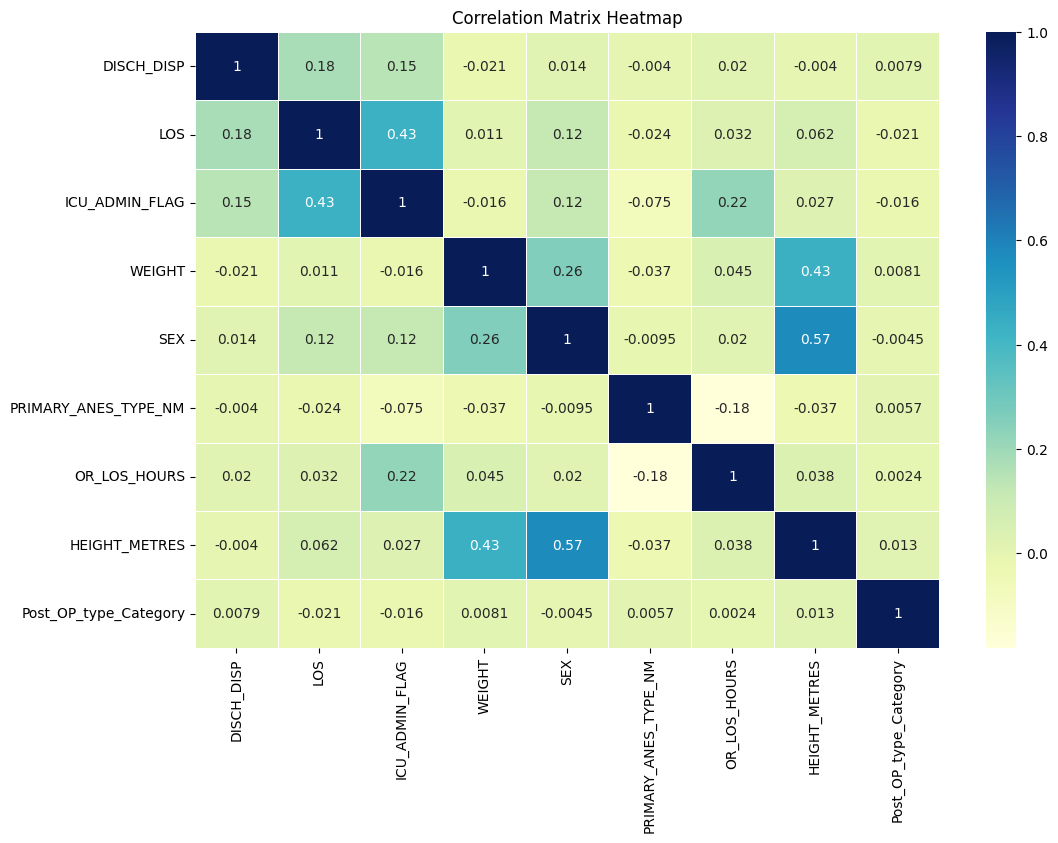

In [92]:
numerical_columns = df_final_disp.select_dtypes(include=['float64', 'int64']).columns

df_numerical = df_final_disp[numerical_columns]

correlation_matrix = df_numerical.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [93]:
balanced_df = pd.DataFrame()
n_sample = 5000

for category in df_final_disp['DISCH_DISP'].unique():
    class_df = df_final_disp[df_final_disp['DISCH_DISP'] == category]

    if len(class_df) > n_sample:
        class_df = resample(class_df, replace=False, n_samples=n_sample, random_state=42)
    elif len(class_df) < n_sample:
        class_df = resample(class_df, replace=True, n_samples=n_sample, random_state=42)

    balanced_df = pd.concat([balanced_df, class_df])


In [94]:
balanced_df.DISCH_DISP.value_counts()

,count
DISCH_DISP,
3,5000
4,5000
8,5000
2,5000
7,5000
0,5000
5,5000
6,5000
1,5000


In [95]:
features = ['LOS', 'ICU_ADMIN_FLAG', 'WEIGHT', 'SEX', 'OR_LOS_HOURS', 'HEIGHT_METRES']
X = balanced_df[features]
y = balanced_df['DISCH_DISP']

In [96]:
# one_hot_encoder = OneHotEncoder(sparse_output=False)
# y_encoded = one_hot_encoder.fit_transform(y.values.reshape(-1, 1))



In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
catboost_model = CatBoostClassifier(iterations=3500, depth=8, learning_rate=0.1, loss_function='MultiClass', verbose=0)

# Train the model
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)

0:	learn: 2.1206935	test: 2.1221131	best: 2.1221131 (0)	total: 295ms	remaining: 17m 11s
100:	learn: 1.3897445	test: 1.4528912	best: 1.4528912 (100)	total: 13s	remaining: 7m 18s
200:	learn: 1.1484060	test: 1.2400895	best: 1.2400895 (200)	total: 23.6s	remaining: 6m 26s
300:	learn: 0.9837622	test: 1.0959173	best: 1.0959173 (300)	total: 30s	remaining: 5m 18s
400:	learn: 0.8674679	test: 0.9939461	best: 0.9939461 (400)	total: 37.1s	remaining: 4m 47s
500:	learn: 0.7740304	test: 0.9140000	best: 0.9140000 (500)	total: 46.2s	remaining: 4m 36s
600:	learn: 0.6973587	test: 0.8492822	best: 0.8492822 (600)	total: 51.5s	remaining: 4m 8s
700:	learn: 0.6379447	test: 0.7978710	best: 0.7978710 (700)	total: 58.1s	remaining: 3m 51s
800:	learn: 0.5855205	test: 0.7538961	best: 0.7538961 (800)	total: 1m 3s	remaining: 3m 34s
900:	learn: 0.5406579	test: 0.7161745	best: 0.7161745 (900)	total: 1m 9s	remaining: 3m 19s
1000:	learn: 0.5025473	test: 0.6838502	best: 0.6838502 (1000)	total: 1m 16s	remaining: 3m 9s
1100:

In [99]:
y_pred_catboost = catboost_model.predict(X_test)
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_catboost))

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       994
           1       0.94      0.99      0.97      1034
           2       0.65      0.51      0.57       985
           3       0.81      0.70      0.75      1026
           4       0.97      1.00      0.98      1020
           5       0.96      1.00      0.98       995
           6       0.94      0.99      0.97       977
           7       0.89      0.98      0.93      1009
           8       0.75      0.75      0.75       960

    accuracy                           0.88      9000
   macro avg       0.87      0.88      0.87      9000
weighted avg       0.87      0.88      0.87      9000



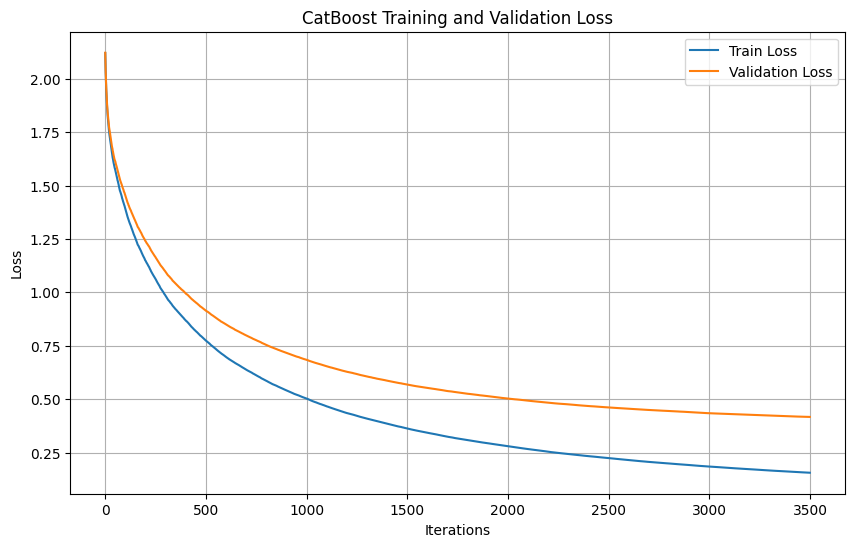

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(catboost_model.get_evals_result()['learn']['MultiClass'], label='Train Loss')
plt.plot(catboost_model.get_evals_result()['validation']['MultiClass'], label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('CatBoost Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


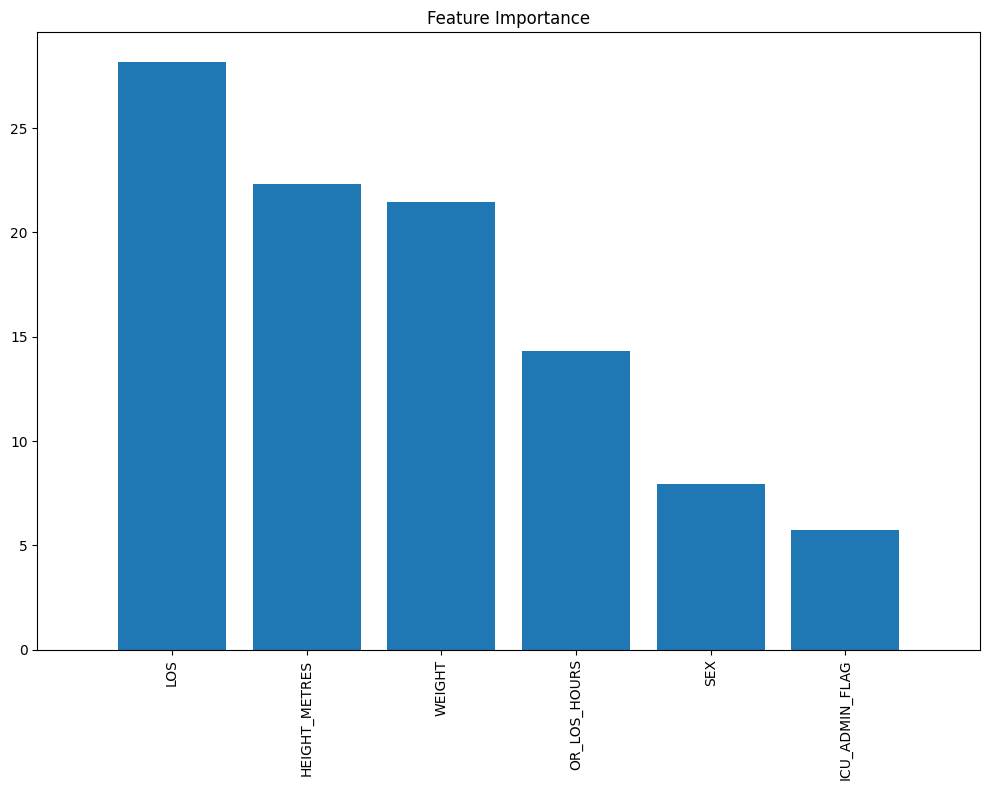

In [101]:
feature_importances = catboost_model.get_feature_importance()

# Get feature names (Assuming X_train has column names)
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

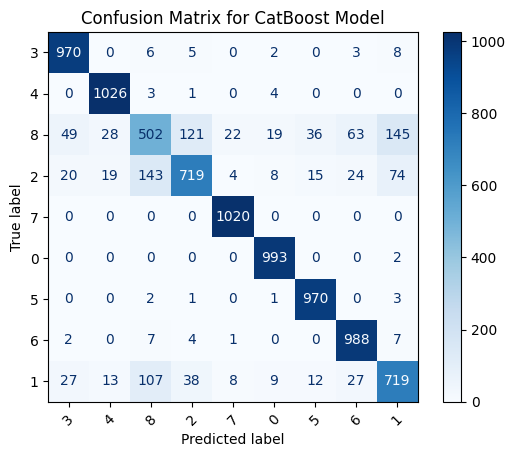

In [102]:
cm = confusion_matrix(y_test, y_pred_catboost)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y.unique())

plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix for CatBoost Model")
plt.show()

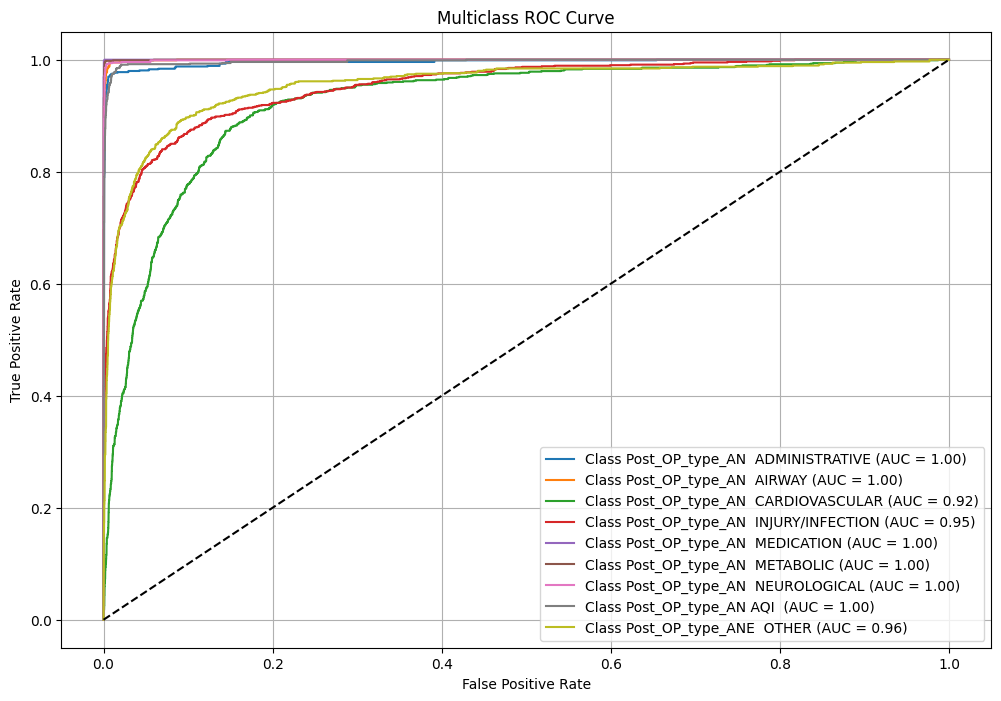

In [103]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(y.unique())))
y_pred_prob = catboost_model.predict_proba(X_test)

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))
for i in range(len(y.unique())):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
catboost_model.save_model('/content/drive/MyDrive/EMR/catboost_model.cbm', format="cbm")

In [107]:
print(catboost.__version__)


1.2.7
